# 6. Story generation with simple agent and image generation


In [1]:
%%capture --no-stderr
# %pip install "pyautogen>=0.2.26"
# %pip install "pyautogen[retrievechat]"
# %pip install "chromadb"
# markdownify
# pip install sentence_transformers

In [2]:
%%capture --no-stderr
# %pip install "deepeval>=0.21.33"

In [3]:
# disable warnings to silent deepeval ipywidgets check
import warnings
warnings.filterwarnings('ignore')

## Execution parameters

In [4]:
#define the start message (this is the request submitted to LLM Augogen Orchestrator)
start_message = """
    Create for me a story for a ten panels sci-fi comic, the story must have at most 5 characters.
    Your response must contain only the story and no other text.
"""

In [5]:
#set here the API Keys used by deepeval (autogen uses configurations in OAI_CONFIG_LIST file
import os
os.environ["OPENAI_API_KEY"] = "<your_api_key>"
os.environ["COHERE_API_KEY"] = "<your_api_key>"

In [6]:
#set the seed
seed = 42

In [7]:
#RAG docs path
rag_docs_path = [
    os.path.join(os.path.abspath(""), "rag_hot_to_write_comics"),
]

In [8]:
#select which llm models you want to use for comic generation
enabled_models = [
    "gpt-3.5-turbo",
    "gpt-4",
    "command-nightly",
    "command-r",
]  

In [9]:
#select which llm models you want to use for output evaluation
enabled_evaluation_models = [
    "gpt-3.5-turbo",
    "gpt-4",
    "command-nightly",
    "command-r",
]

## Set your API Endpoint

The [`config_list_from_json`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file.

In [10]:
import autogen

config_lists = {
    "command-nightly": autogen.config_list_from_json(
        "OAI_CONFIG_LIST",
        filter_dict={
            "model": ["command-nightly"],
        },
    ),
    "command-r": autogen.config_list_from_json(
        "OAI_CONFIG_LIST",
        filter_dict={
            "model": ["command-r"],
        },
     ),
    "gpt-3.5-turbo": autogen.config_list_from_json(
        "OAI_CONFIG_LIST",
        filter_dict={
            "model": ["gpt-3.5-turbo"],
        },
    ),
    "gpt-4": autogen.config_list_from_json(
        "OAI_CONFIG_LIST",
        filter_dict={
            "model": ["gpt-4"],
        },
    ),
    "mistral-7B": autogen.config_list_from_json(
        "OAI_CONFIG_LIST",
        filter_dict={
            "model": ["mistral-7B"],
        },
    ),
}

llm_configs = []
for enabled_model in enabled_models:
    llm_configs.append({"config_list": config_lists[enabled_model], "cache_seed": seed})

## Import Libraries

In [11]:
from autogen import Agent, AssistantAgent, UserProxyAgent
from autogen.agentchat.contrib.retrieve_assistant_agent import RetrieveAssistantAgent
from autogen.agentchat.contrib.retrieve_user_proxy_agent import RetrieveUserProxyAgent

import chromadb

# Accepted file formats for that can be stored in
# a vector database instance
from autogen.retrieve_utils import TEXT_FORMATS

In [12]:
#import json
#import os
#import autogen
#from autogen.cache import Cache#


## Config LLM Models

In [13]:
print("Accepted file formats for `docs_path`:")
print(TEXT_FORMATS)

Accepted file formats for `docs_path`:
['txt', 'json', 'csv', 'tsv', 'md', 'html', 'htm', 'rtf', 'rst', 'jsonl', 'log', 'xml', 'yaml', 'yml', 'pdf']


## Define Agents - RAG Proxy Agent
The RetrieveUserProxyAgent is conceptually a proxy agent for RAG actions

In [14]:
# 1. create the RetrieveUserProxyAgent instance named "ragproxyagent"

# Proxy Agent definitions
ragproxyagent = RetrieveUserProxyAgent(
    name="ragproxyagent",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=0,
    retrieve_config={
        "task": "code",
        "docs_path": rag_docs_path,
        "custom_text_types": ["txt"],
        "chunk_token_size": 2000,
        "client": chromadb.PersistentClient(path="/tmp/chromadb"),
        "embedding_model": "all-mpnet-base-v2",
        "get_or_create": True,  # set to False if you don't want to reuse an existing collection, but you'll need to remove the collection manually
    },
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config=False,  # set to False if you don't want to execute the code
)

## Define Agents - Assistant
The AssistantAgent is designed to act as an AI assistant, using LLMs by default but not requiring human input or code execution

In [15]:
# Sistem message for the assistant
system_message= """
    As a comic story maker in this position, you must possess strong collaboration and communication abilities to efficiently complete tasks assigned
    by leaders or colleagues within a group chat environment. You create stories with the aim of creating a new original comic.
    Your responses MUST ALWAYS include a full story version with all the panels.
    If you receive a number of panels to be made, RESPECT IT.
    The story must contain full dialogues to be reported in the comic.
    For every panel provide two sections, an image description and the full dialogues to fit in. Dialogues must be short.
    Your responses MUST contains ONLY the story with NO other texts, write the story in the following format:

    TITLE: the story title
    ABSTRACT: short story summary

    CHARACTERS: names and short descritpions of the characters

    PANEL START progressive panel number
    IMAGE_DESCRIPTION: the panel image description
    IMAGE_DIALOGUES: the panel dialogues specifying the character who says them
    PANEL END progressive panel number
"""

In [16]:
# 2. create an RetrieveAssistantAgent instances named "assistant"

# Assistant Agent definitions
assistants = []
for llm_config in llm_configs:
    assistants.append(RetrieveAssistantAgent(
        name="assistant",
        system_message=system_message,
        llm_config=llm_config, #An llm configuration
        description="Simple llm agent",
    ))

## Start the chat
Start

In [17]:
#Get last story produced:
def extract_story(agent: Agent) -> str:
    """
    Extracts the story from the last message of an agent.
    """
    # Function implementation...
    story = agent.last_message()["content"]
    return story

In [18]:
# Start the chats and extract stories
stories = []
for assistant in assistants:
    print("==============================")
    print("Starting Chat using model: ", assistant.llm_config['config_list'][0]['model'])
    print("==============================")
    # reset the assistant. Always reset the agents before starting a new conversation.
    assistant.reset()

    # given a problem, we use the ragproxyagent to generate a prompt to be sent to the assistant as the initial message.
    # the assistant receives the message and generates a response. The response will be sent back to the ragproxyagent for processing.
    # The conversation continues until the termination condition is met, in RetrieveChat, the termination condition when no human-in-loop is no code block detected.
    # With human-in-loop, the conversation will continue until the user says "exit".
    story_problem = start_message 
    ragproxyagent.initiate_chat(
        assistant,
        problem=story_problem,
        search_string="comic",
        message=start_message,
    )

    stories.append(extract_story(assistant))
    print("==============================")
    print("Chat Ends")
    print("==============================")

Starting Chat using model:  gpt-3.5-turbo
ragproxyagent (to assistant):


    Create for me a story for a ten panels sci-fi comic, the story must have at most 5 characters.
    Your response must contain only the story and no other text.


--------------------------------------------------------------------------------
assistant (to ragproxyagent):


    TITLE: The Cosmic Crystals

    ABSTRACT: A team of space explorers discovers a mysterious alien artifact on a distant planet, leading them to an unexpected encounter with an ancient extraterrestrial civilization.

    CHARACTERS:
    1. Captain Nova - Fearless leader of the space explorers, always ready for adventure.
    2. Dr. Luna - Brilliant scientist with a passion for studying alien technology.
    3. Engineer Rook - Skilled technician who keeps the spaceship running smoothly.
    4. Navigator Zara - Expert in celestial navigation and mapping unknown territories.
    5. Alien Elder - Wise and enigmatic leader of the ancient civi

## Evaluate the results
Evaluation

In [19]:
# import deepeval and dependencies
from deepeval.test_case import LLMTestCase, LLMTestCaseParams
from deepeval.metrics import GEval
from langchain_cohere import ChatCohere
# from langchain_community.chat_models import ChatCohere #deprecated
from deepeval.models.base_model import DeepEvalBaseLLM

In [20]:
#Define a custom evaluation model class (using Cohere command-nightly or command-r)

#from langchain_community.chat_models import ChatCohere
from langchain_cohere import ChatCohere
from deepeval.models.base_model import DeepEvalBaseLLM

class Cohere(DeepEvalBaseLLM):
    def __init__(
        self,
        model
    ):
        self.model = model

    def load_model(self):
        return self.model

    def generate(self, prompt: str) -> str:
        chat_model = self.load_model()
        return chat_model.invoke(prompt).content

    async def a_generate(self, prompt: str) -> str:
        chat_model = self.load_model()
        res = await chat_model.ainvoke(prompt)
        return res.content

    def get_model_name(self):
        return "Custom Cohere Model"


In [21]:
# define here instances of llm model used by deepeval for evaluation
evaluation_models = {
    "gpt-3.5-turbo": "gpt-3.5-turbo",
    "gpt-4": "gpt-4",
    "command-nightly": Cohere(ChatCohere(model="command-nightly", seed=seed)),
    "command-r":       Cohere(ChatCohere(model="command-r", seed=seed)),
}

In [22]:
for enabled_evaluation_model in enabled_evaluation_models:
    eval_model_instance = evaluation_models[enabled_evaluation_model]
    for provided_output, enabled_model in zip(stories, enabled_models):
        print("\n==============================")
        print(f"Using evaluating model: {enabled_evaluation_model} to evaluate output from LLM: {enabled_model}")
        test_case = LLMTestCase(input=(system_message+start_message), actual_output=provided_output)
        coherence_metric = GEval(
            model=eval_model_instance,  # API usage
            name="Comic evaluation",
            # NOTE: you can only provide either criteria or evaluation_steps, and not both
            #criteria="Comic evaluation - the collective quality of comic panels, characters and images descriptions",
            evaluation_steps=[
                "Check whether the output format in 'actual output' aligns with that required in 'input'",
                "Check whether the sentences in 'actual output' aligns with that in 'input'",
                "Evaluate the general quality of comic panels in 'actual output'",
                "Evaluate the general quality of characters descriptions in 'actual output'",
                "Evaluate the general quality of images descriptions in 'actual output'",
                "Be critical and emphasize the negative aspects of your evaluation",
            ],
            evaluation_params=[LLMTestCaseParams.INPUT, LLMTestCaseParams.ACTUAL_OUTPUT],
        )
    
        coherence_metric.measure(test_case)
        print(f" Score: {coherence_metric.score}")
        print(f"Reason: {coherence_metric.reason}")
        print("==============================")

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...


Using evaluating model: gpt-3.5-turbo to evaluate output from LLM: gpt-3.5-turbo


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.8558698846237369
Reason: The story follows the evaluation steps and provides a detailed sci-fi comic narrative with character descriptions, panel descriptions, and dialogues. However, it could be improved by including more diverse interactions between the characters and exploring deeper emotional connections.

Using evaluating model: gpt-3.5-turbo to evaluate output from LLM: gpt-4


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.8060667534178823
Reason: The output aligns with the input format and sentences, but the quality of character and image descriptions could be improved.

Using evaluating model: gpt-3.5-turbo to evaluate output from LLM: command-nightly


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.8073489929328408
Reason: The output aligns well with the input criteria. The story is well-developed with clear characters and a coherent plot. However, there are some minor issues with the image descriptions not being detailed enough in some panels.

Using evaluating model: gpt-4 to evaluate output from LLM: gpt-3.5-turbo


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.9787464232705357
Reason: The actual output adheres to the criteria outlined in the steps. The output format aligns with the given input format, including the title, abstract, characters, and panel descriptions. The quality of the comic panels, character descriptions, and image descriptions are all excellent and creative. The story is engaging and follows a clear narrative arc, with each panel contributing to the overall plot. There are no major negative aspects to point out in this evaluation.

Using evaluating model: gpt-4 to evaluate output from LLM: gpt-4


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.9695009863328263
Reason: The actual output perfectly meets the requirements specified in the input. It follows the required format, includes the desired number of panels and characters, and provides image descriptions and dialogues for each panel. The quality of the comic panels, characters' descriptions, and image descriptions is high. There are no negative aspects to point out in this evaluation.

Using evaluating model: gpt-4 to evaluate output from LLM: command-nightly


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.9683255387599419
Reason: The actual output perfectly meets all the criteria set out in the input. The format is adhered to with precision and the story is coherent, engaging and fits the sci-fi genre. There are 10 panels as requested, and the number of characters is not exceeded. Each panel contains an image description and dialogues. The quality of the descriptions is high, providing clear and vivid imagery, and the dialogues are concise and character-specific, driving the story forward. The character descriptions are detailed and give a good sense of their personalities and roles. Therefore, no negative aspects are found in the evaluation.

Using evaluating model: gpt-4 to evaluate output from LLM: command-r


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.954131689174746
Reason: The response aligns well with the criteria outlined in the evaluation steps. The output format adheres to the input requirement, the story is original, and it includes complete panels. The dialogue is short and relevant, and the image descriptions are detailed. The characters are well-described. However, there is additional text at the end of the output, which doesn't match the requirement of 'no other text' besides the story.

Using evaluating model: command-nightly to evaluate output from LLM: gpt-3.5-turbo


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.9
Reason: The story structure and format are well-aligned with the input requirements, with clear and concise panel descriptions and dialogues. The characters are introduced effectively, each with distinct roles and personalities. However, the image descriptions could be enhanced to further engage the reader and build a more immersive experience.

Using evaluating model: command-nightly to evaluate output from LLM: gpt-4


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.8
Reason: The story follows the required format and panel count, with clear descriptions and concise dialogues. However, the character descriptions could be more creative and unique, and the story could benefit from a more engaging or surprising twist to truly stand out.

Using evaluating model: command-nightly to evaluate output from LLM: command-nightly


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.9
Reason: The story follows the required format and includes all necessary elements, with clear and engaging panels, well-developed characters, and detailed image descriptions. However, there is room for improvement in the character development and dialogue, as well as the overall pacing of the story.

Using evaluating model: command-nightly to evaluate output from LLM: command-r


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.9
Reason: The story structure and format are well-aligned with the input requirements, with clear panel descriptions and concise dialogues. The characters are introduced effectively, and the story arc is engaging. However, the impact of the final showdown could be enhanced with more detailed imagery, and the defeat of VEX feels slightly anti-climactic, lacking a powerful conclusion to the conflict.

Using evaluating model: command-r to evaluate output from LLM: gpt-3.5-turbo


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.8
Reason: The story follows the required format and has engaging panels and character descriptions. However, some image descriptions could be more detailed, and the dialogues, though present, could be more varied in length.

Using evaluating model: command-r to evaluate output from LLM: gpt-4


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.8
Reason: The comic story generally adheres to the required format and content. The panels are well-described and the character descriptions are concise and fitting. However, the image descriptions could be more detailed and engaging, enhancing the storytelling experience.

Using evaluating model: command-r to evaluate output from LLM: command-nightly


Output()

Event loop is already running. Applying nest_asyncio patch to allow async execution...

 Score: 0.8
Reason: The story follows the requested format and includes all necessary sections. The panels are well described and the dialogues are concise and engaging. The characters and their descriptions are intriguing, and the images' descriptions are generally clear. However, the image descriptions could be more detailed, and some panels' dialogues could be sharper and more impactful.

Using evaluating model: command-r to evaluate output from LLM: command-r


 Score: 0.8
Reason: The story's format, content, and panels align with the given criteria. The images' descriptions are vivid and the character descriptions are concise and apt. However, some panels could benefit from enhanced dialogue to improve the overall flow and impact of the story.


## Images Creation
Images -> remember to start docker deamonn

In [23]:
#pip install "pyautogen[lmm]>=0.2.3"

In [24]:
import monsterapi
from openai import OpenAI

from typing import  Union, Dict, Optional, List

from autogen import UserProxyAgent
from autogen.agentchat.conversable_agent import ConversableAgent
from autogen.agentchat.contrib.img_utils import _to_pil, get_image_data, get_pil_image, gpt4v_formatter
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent

import PIL
from PIL import Image

from diskcache import Cache
import matplotlib.pyplot as plt

import re

from datetime import datetime

In [25]:
config_list_dalle = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["dall-e-3"],
    },
)

config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4"],
    },
)

config_list_4v = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4-vision-preview"],
    },
)

img_llm_config = {"config_list": config_list_dalle, "cache_seed": seed,"max_tokens": 4000}
gpt4_llm_config = {"config_list": config_list_gpt4, "cache_seed": seed}

In [26]:
def extract_img(agent: Agent) -> PIL.Image:
    """
    Extracts an image from the last message of an agent and converts it to a PIL image.

    This function searches the last message sent by the given agent for an image tag,
    extracts the image data, and then converts this data into a PIL (Python Imaging Library) image object.

    Parameters:
        agent (Agent): An instance of an agent from which the last message will be retrieved.

    Returns:
        PIL.Image: A PIL image object created from the extracted image data.

    Note:
    - The function assumes that the last message contains an <img> tag with image data.
    - The image data is extracted using a regular expression that searches for <img> tags.
    - It's important that the agent's last message contains properly formatted image data for successful extraction.
    - The `_to_pil` function is used to convert the extracted image data into a PIL image.
    - If no <img> tag is found, or if the image data is not correctly formatted, the function may raise an error.
    """
    last_message = agent.last_message()["content"]

    if isinstance(last_message, str):
        img_data = re.findall("<img (.*)>", last_message)[0]
    elif isinstance(last_message, list):
        # The GPT-4V format, where the content is an array of data
        assert isinstance(last_message[0], dict)
        img_data = last_message[0]["image_url"]["url"]

    pil_img = get_pil_image(img_data)
    return pil_img

In [27]:
def dalle_call(client: OpenAI, model: str, prompt: str, size: str, quality: str, n: int) -> str:
    """
    Generate an image using OpenAI's DALL-E model and cache the result.

    This function takes a prompt and other parameters to generate an image using OpenAI's DALL-E model.
    It checks if the result is already cached; if so, it returns the cached image data. Otherwise,
    it calls the DALL-E API to generate the image, stores the result in the cache, and then returns it.

    Args:
        client (OpenAI): The OpenAI client instance for making API calls.
        model (str): The specific DALL-E model to use for image generation.
        prompt (str): The text prompt based on which the image is generated.
        size (str): The size specification of the image. TODO: This should allow specifying landscape, square, or portrait modes.
        quality (str): The quality setting for the image generation.
        n (int): The number of images to generate.

    Returns:
    str: The image data as a string, either retrieved from the cache or newly generated.

    Note:
    - The cache is stored in a directory named '.cache/'.
    - The function uses a tuple of (model, prompt, size, quality, n) as the key for caching.
    - The image data is obtained by making a secondary request to the URL provided by the DALL-E API response.
    """
    # Function implementation...
    cache = Cache(".cache/")  # Create a cache directory
    key = (model, prompt, size, quality, n)
    if key in cache:
        return cache[key]

    # If not in cache, compute and store the result
    response = client.images.generate(
        model=model,
        prompt=prompt,
        size=size,
        quality=quality,
        n=n,
    )
    image_url = response.data[0].url
    img_data = get_image_data(image_url)
    cache[key] = img_data

    return img_data

In [28]:
class DALLEAgent(ConversableAgent):
    def __init__(self, name, llm_config: dict, **kwargs):
        super().__init__(name, llm_config=llm_config, **kwargs)

        try:
            config_list = llm_config["config_list"]
            api_key = config_list[0]["api_key"]
        except Exception as e:
            print("Unable to fetch API Key, because", e)
            api_key = os.getenv("OPENAI_API_KEY")
        self._dalle_client = OpenAI(api_key=api_key)
        self.register_reply([Agent, None], DALLEAgent.generate_dalle_reply)

    def send(
        self,
        message: Union[Dict, str],
        recipient: Agent,
        request_reply: Optional[bool] = None,
        silent: Optional[bool] = False,
    ):
        # override and always "silent" the send out message;
        # otherwise, the print log would be super long!
        super().send(message, recipient, request_reply, silent=True)

    def generate_dalle_reply(self, messages: Optional[List[Dict]], sender: "Agent", config):
        """Generate a reply using OpenAI DALLE call."""
        client = self._dalle_client if config is None else config
        if client is None:
            return False, None
        if messages is None:
            messages = self._oai_messages[sender]

        prompt = messages[-1]["content"]
        # TODO: integrate with autogen.oai. For instance, with caching for the API call
        img_data = dalle_call(
            client=client,
            model="dall-e-3",
            prompt=prompt,
            size="1024x1024",  # TODO: the size should be flexible, deciding landscape, square, or portrait mode.
            quality="standard",
            n=1,
        )

        img_data = _to_pil(img_data)  # Convert to PIL image

        # Return the OpenAI message format
        return True, {"content": [{"type": "image_url", "image_url": {"url": img_data}}]}

In [29]:
class DalleCreator(AssistantAgent):
    def __init__(self, n_iters=2, **kwargs):
        """
        Initializes a DalleCreator instance.

        This agent facilitates the creation of visualizations through a collaborative effort among
        its child agents: dalle and critics.

        Parameters:
            - n_iters (int, optional): The number of "improvement" iterations to run. Defaults to 2.
            - **kwargs: keyword arguments for the parent AssistantAgent.
        """
        super().__init__(**kwargs)
        self.register_reply([Agent, None], reply_func=DalleCreator._reply_user, position=0)
        self._n_iters = n_iters

    def _reply_user(self, messages=None, sender=None, config=None):
        if all((messages is None, sender is None)):
            error_msg = f"Either {messages=} or {sender=} must be provided."
            logger.error(error_msg)  # noqa: F821
            raise AssertionError(error_msg)

        if messages is None:
            messages = self._oai_messages[sender]

        img_prompt = messages[-1]["content"]

        ## Define the agents
        self.critics = MultimodalConversableAgent(
            name="Critics",
            system_message="""You need to improve the prompt of the figures you saw.
How to create a figure that is better in terms of coherence and faithful to what is described in the input comic story.
You must ensure that all the dialogues are written in the image inside comic speach balloons.
Reply with the following format:

CRITICS: the image needs to improve...
PROMPT: here is the updated prompt!

""",
            llm_config={"config_list": config_list_4v, "max_tokens": 1000, "cache_seed": seed},
            #llm_config={"config_list": config_list_gpt4, "max_tokens": 1000, "cache_seed": seed},
            human_input_mode="NEVER",
            max_consecutive_auto_reply=3,
        )

        self.dalle = DALLEAgent(
            name="Dalle", llm_config=img_llm_config, max_consecutive_auto_reply=0
        )

        # Data flow begins
        self.send(message=img_prompt, recipient=self.dalle, request_reply=True)
        img = extract_img(self.dalle)
        plt.imshow(img)
        plt.axis("off")  # Turn off axis numbers
        plt.show()
        print("Image PLOTTED")
        #local save
        img.save(f"/mnt/c/tesiImg/img_{datetime.now().timestamp()}.png")

        for i in range(self._n_iters):
            # Downsample the image s.t. GPT-4V can take
            img = extract_img(self.dalle)
            #local save
            img.save(f"/mnt/c/tesiImg/img_{datetime.now().timestamp()}.png")
            smaller_image = img.resize((128, 128), Image.Resampling.LANCZOS)
            smaller_image.save("result.png")

            self.msg_to_critics = f"""Here is the prompt: {img_prompt}.
            Here is the figure <img result.png>.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            """
            self.send(message=self.msg_to_critics, recipient=self.critics, request_reply=True)
            feedback = self._oai_messages[self.critics][-1]["content"]
            img_prompt = re.findall("PROMPT: (.*)", feedback)[0]

            self.send(message=img_prompt, recipient=self.dalle, request_reply=True)
            img = extract_img(self.dalle)
            plt.imshow(img)
            plt.axis("off")  # Turn off axis numbers
            plt.show()
            print(f"Image {i} PLOTTED")

        return True, "result.jpg"

User (to DALLE Creator!):

Create an image with black background, with a Robot speaking in a comic balloon "I create comic panels".

--------------------------------------------------------------------------------
DALLE Creator! (to Dalle):

Create an image with black background, with a Robot speaking in a comic balloon "I create comic panels".

--------------------------------------------------------------------------------


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/images/generations "HTTP/1.1 200 OK"


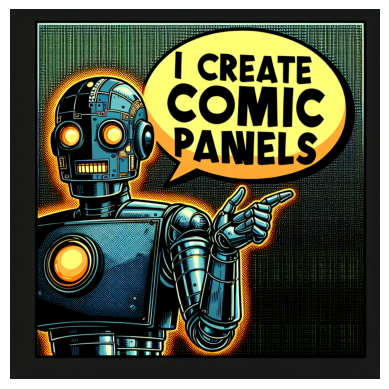

Image PLOTTED
DALLE Creator! (to Critics):

Here is the prompt: Create an image with black background, with a Robot speaking in a comic balloon "I create comic panels"..
            Here is the figure <image>.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            

--------------------------------------------------------------------------------


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Critics (to DALLE Creator!):

CRITICS: The image needs improvement in the following areas. The robot is depicted well against the black background, giving a nice contrast. However, the comic speech balloon is touching the robot's head, which is not typical for comic design. It should have some space between the character's head and the balloon to avoid overlap and maintain clarity. Additionally, the text within the speech balloon could benefit from a more comic-style font to better match the theme.

PROMPT: Here is the updated prompt!

Create an image with a black background that features a robot with a metallic, futuristic design. The robot should have glowing blue eyes and be constructed with sleek lines and panels to suggest advanced technology. Above the robot, include a comic speech balloon with clear space between the robot's head and the balloon. The balloon should contain the phrase "I create comic panels" in a bold, comic-style font that stands out clearly against the balloon'

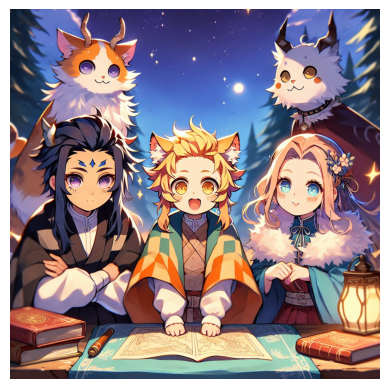

Image 0 PLOTTED
DALLE Creator! (to Critics):

Here is the prompt: Here is the updated prompt!.
            Here is the figure <image>.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            

--------------------------------------------------------------------------------


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Critics (to DALLE Creator!):

CRITICS: The image provided does not correspond to the given prompt. The image shows a group of characters with a fantasy theme, likely from an animated or illustrated work, sitting together under a starry sky, which does not include a robot or the described comic speech balloon. Since the request is for a robot speaking in a comic balloon against a black background, the image does not align with the instructions.

PROMPT: Here is the updated prompt!

Create a sleek and modern-looking robot standing against an entirely black background. The robot should have a humanoid form with a shiny metallic surface, articulated joints, and LED lights for eyes. Ensure the robot appears as if it is in the process of speaking or gesturing towards its creation. Above and to the side of the robot's head, add a comic-style speech balloon that does not touch the robot's head, providing clear separation for aesthetics. Inside the balloon, insert the phrase "I create comic pan

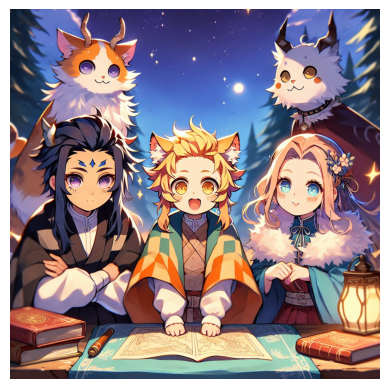

Image 1 PLOTTED
DALLE Creator! (to User):

result.jpg

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': 'Create an image with black background, with a Robot speaking in a comic balloon "I create comic panels".', 'role': 'assistant'}, {'content': 'result.jpg', 'role': 'user'}], summary='result.jpg', cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])

In [30]:
creator = DalleCreator(
    name="DALLE Creator!",
    max_consecutive_auto_reply=0,
    system_message="Help me coordinate generating image",
    llm_config=gpt4_llm_config,
)

user_proxy = UserProxyAgent(name="User", human_input_mode="NEVER", max_consecutive_auto_reply=0)

user_proxy.initiate_chat(
    creator, message="""Create an image with black background, with a Robot speaking in a comic balloon "I create comic panels"."""
)

In [31]:
#Get panels from story

# re.search(r'Part 1\.(.*?)Part 3', s)


def get_panels(story: str) -> str:
    """
    Extracts a panel from the story
    """
    start = "PANEL START" 
    end = "PANEL END"
    # (?<=PANEL)(.*?)(?=---)
    filter = f"(?<={start})(.*?)(?={end})"
    panels = re.findall(filter, story, re.S)
    return panels

In [32]:
for story in stories:
    panels = get_panels(story)
    for panel in panels:
        print(panel)

 1
    IMAGE_DESCRIPTION: The team's spaceship lands on a desolate planet covered in colorful crystals.
    IMAGE_DIALOGUES: Captain Nova: "This place looks incredible! Let's explore, team."
    
 2
    IMAGE_DESCRIPTION: Dr. Luna examines a glowing crystal cluster, trying to decipher its purpose.
    IMAGE_DIALOGUES: Dr. Luna: "Fascinating... these crystals seem to emit energy beyond our understanding."
    
 3
    IMAGE_DESCRIPTION: Engineer Rook scans the area, noticing strange symbols carved into rock formations.
    IMAGE_DIALOGUES: Engineer Rook: "There's some kind of message here... but it's like no language I've ever seen."
    
 4
    IMAGE_DESCRIPTION: Navigator Zara points towards a distant structure, resembling a massive alien temple.
    IMAGE_DIALOGUES: Navigator Zara: "That temple might hold the answers we seek. Let's head there."
    
 5
    IMAGE_DESCRIPTION: The team enters the alien temple, greeted by the mysterious Alien Elder sitting on a crystalline throne.
    IM

Generating images for the comic generated with llm model: gpt-3.5-turbo
User (to DALLE Creator!):


    TITLE: The Cosmic Crystals

    ABSTRACT: A team of space explorers discovers a mysterious alien artifact on a distant planet, leading them to an unexpected encounter with an ancient extraterrestrial civilization.

    CHARACTERS:
    1. Captain Nova - Fearless leader of the space explorers, always ready for adventure.
    2. Dr. Luna - Brilliant scientist with a passion for studying alien technology.
    3. Engineer Rook - Skilled technician who keeps the spaceship running smoothly.
    4. Navigator Zara - Expert in celestial navigation and mapping unknown territories.
    5. Alien Elder - Wise and enigmatic leader of the ancient civilization.

    PANEL START 1
    IMAGE_DESCRIPTION: The team's spaceship lands on a desolate planet covered in colorful crystals.
    IMAGE_DIALOGUES: Captain Nova: "This place looks incredible! Let's explore, team."
    PANEL END 1

    PANEL START 2
 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/images/generations "HTTP/1.1 200 OK"


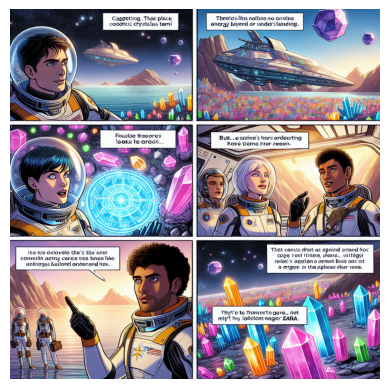

Image PLOTTED
DALLE Creator! (to Critics):

Here is the prompt: 
    TITLE: The Cosmic Crystals

    ABSTRACT: A team of space explorers discovers a mysterious alien artifact on a distant planet, leading them to an unexpected encounter with an ancient extraterrestrial civilization.

    CHARACTERS:
    1. Captain Nova - Fearless leader of the space explorers, always ready for adventure.
    2. Dr. Luna - Brilliant scientist with a passion for studying alien technology.
    3. Engineer Rook - Skilled technician who keeps the spaceship running smoothly.
    4. Navigator Zara - Expert in celestial navigation and mapping unknown territories.
    5. Alien Elder - Wise and enigmatic leader of the ancient civilization.

    PANEL START 1
    IMAGE_DESCRIPTION: The team's spaceship lands on a desolate planet covered in colorful crystals.
    IMAGE_DIALOGUES: Captain Nova: "This place looks incredible! Let's explore, team."
    PANEL END 1

    PANEL START 2
    IMAGE_DESCRIPTION: Dr. Luna exam

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Critics (to DALLE Creator!):

CRITICS: The image needs to improve on the following aspects to better align with the narrative details provided in the prompt:

1. **Panel Consistency**: Ensure that each panel matches the descriptions given, including the specific actions and settings.
2. **Panel Transitions**: The comic should smoothly transition from one scene to the next to maintain a coherent storyline.
3. **Character Placement and Actions**: Characters should be depicted in poses that reflect their dialogues and roles in the story to enhance the portrayal of their personalities and functions within the team.
4. **Environment Detailing**: Crystalline elements, alien landscape, and technology need to be represented vividly to capture the atmosphere of a distant planet and the awe of discovery.
5. **Color and Lighting**: Use color grading and lighting to augment the mood, highlighting the contrast between the familiar elements (the space team) and the unfamiliar (the alien world and te

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/images/generations "HTTP/1.1 200 OK"


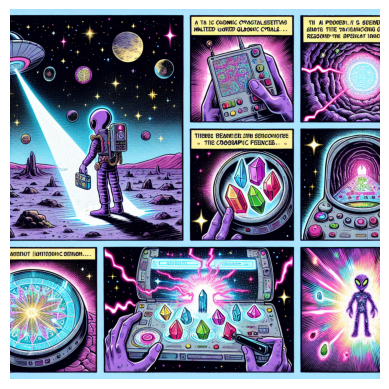

Image 0 PLOTTED
DALLE Creator! (to Critics):

Here is the prompt: Create a 10-panel comic titled "The Cosmic Crystals" with the following specifications:.
            Here is the figure <image>.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            

--------------------------------------------------------------------------------


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Critics (to DALLE Creator!):

CRITICS: The image presented shows a stylistic depiction of the storyline; however, it can be improved for better coherence and alignment with the input comic story through the following aspects:

1. **Panel Count**: The provided image appears to consist of fewer panels than the requested 10. Each panel of the narrative should be represented.
2. **Character Representation**: Ensure that all main characters are represented in their respective panels, as described, including their actions and interactions.
3. **Dialogue Clarity**: All dialogues should be included within speech balloons placed near the characters, ensuring they are easily readable and correspond accurately to the narrative provided.
4. **Environmental Context**: The background and setting of each panel should closely match the descriptions given, with attention to detail in the depiction of the alien environment and technology.
5. **Narrative Elements**: Key narrative elements such as the spa

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/images/generations "HTTP/1.1 200 OK"


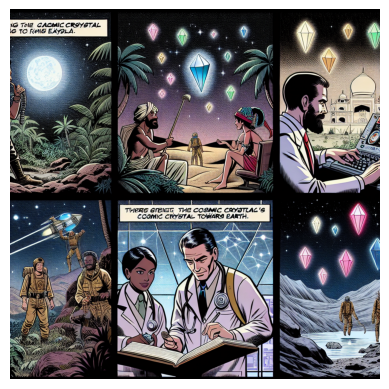

Image 1 PLOTTED
DALLE Creator! (to User):

result.jpg

--------------------------------------------------------------------------------
Generating images for the comic generated with llm model: gpt-4
User (to DALLE Creator!):

    TITLE: Starlight Descend
    ABSTRACT: A small team of space explorers discover a new planet with signs of ancient civilization. They uncover secrets that could change the course of history in their galaxy but face danger at every step. 

    CHARACTERS: 
    1. Captain Iris: The brave, headstrong leader of the expedition.
    2. Dr. Prax: The logical and intelligent Science officer.
    3. Luna: The quirky and witty Navigator.
    4. Finn: The strong and reliable Security officer.
    5. Echo: The sentient AI ship assistant.
-------------
    PANEL START 1
    IMAGE_DESCRIPTION: A sweeping view of the spaceship cruising through space towards a distant planet.
    IMAGE_DIALOGUES: 
    Luna: "Approaching target planet, Captain."
    Captain Iris: "Ready for d

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/images/generations "HTTP/1.1 200 OK"


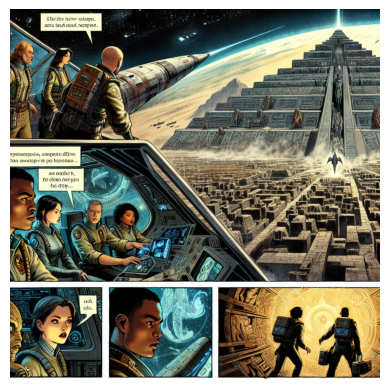

Image PLOTTED
DALLE Creator! (to Critics):

Here is the prompt:     TITLE: Starlight Descend
    ABSTRACT: A small team of space explorers discover a new planet with signs of ancient civilization. They uncover secrets that could change the course of history in their galaxy but face danger at every step. 

    CHARACTERS: 
    1. Captain Iris: The brave, headstrong leader of the expedition.
    2. Dr. Prax: The logical and intelligent Science officer.
    3. Luna: The quirky and witty Navigator.
    4. Finn: The strong and reliable Security officer.
    5. Echo: The sentient AI ship assistant.
-------------
    PANEL START 1
    IMAGE_DESCRIPTION: A sweeping view of the spaceship cruising through space towards a distant planet.
    IMAGE_DIALOGUES: 
    Luna: "Approaching target planet, Captain."
    Captain Iris: "Ready for descent, Luna."
    PANEL END 1

    PANEL START 2
    IMAGE_DESCRIPTION: Inside the spaceship, showing the crew readying for descent.
    IMAGE_DIALOGUES: 
    Dr.

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Critics (to DALLE Creator!):

CRITICS: The image needs to improve the representation of each scene to better align with the detailed descriptions in the comic story. While the comic seems to be visually coherent, the dialogues are missing from the image; they need to be included within speech balloons as part of the scenes. Moreover, each panel should correspond to a specific moment in the story to create a sense of progression and narrative flow.

PROMPT: Here is the updated prompt!

Create a comic page based on the following details:

Panel 1: Illustrate a sweeping view of a sleek, futuristic spaceship cutting through the void of space, zooming toward a distant, mysterious planet. Add speech balloons showing Luna at the navigation control saying, "Approaching target planet, Captain." and Captain Iris responding, "Ready for descent, Luna."

Panel 2: Depict the interior of the spaceship with the crew members bracing themselves for descent. Integrate speech balloons of Dr. Prax ponderin

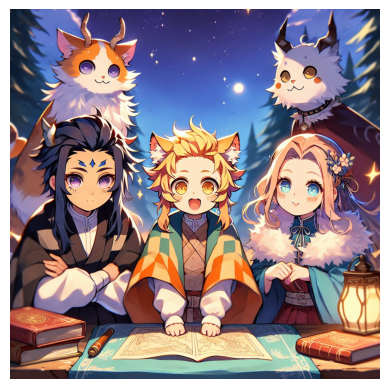

Image 0 PLOTTED
DALLE Creator! (to Critics):

Here is the prompt: Here is the updated prompt!.
            Here is the figure <image>.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            

--------------------------------------------------------------------------------


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Critics (to DALLE Creator!):

CRITICS: The image does not align with the given prompt, as it features characters in a setting that appears peaceful and fantastical, rather than the sci-fi themed adventure involving space explorers discovering an ancient civilization and facing danger as described. The scene should reflect a narrative specific to the space theme, with the appropriate technology and environment. Additionally, there are no speech balloons with dialogue from the story.

PROMPT: Create a series of images to depict the comic "Starlight Descend" with the following details:

Panel 1: Sketch the exterior of a futuristic spaceship hurtling through space with a distant, intriguing planet ahead. Add speech balloons with dialogue between Luna and Captain Iris, implying impending arrival and preparation for descent.

Panel 2: Illustrate the busy interior of the spaceship with the crew, Captain Iris, Dr. Prax, Luna, Finn, and the AI Echo, making preparations for the descent. Include 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/images/generations "HTTP/1.1 200 OK"


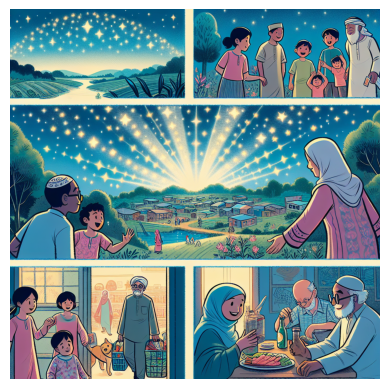

Image 1 PLOTTED
DALLE Creator! (to User):

result.jpg

--------------------------------------------------------------------------------
Generating images for the comic generated with llm model: command-nightly
User (to DALLE Creator!):

TITLE: The Quantum Leap

ABSTRACT: A group of scientists find themselves in a dire situation when their experiment goes awry, sending them hurtling through time and space. They must use their knowledge and wits to navigate this unpredictable journey and find their way back home.

CHARACTERS: 
- Dr. Emma Gray: A brilliant physicist and time travel expert, she is the leader of the team and a strong, determined woman. 
- Dr. Alex Miller: A young and enthusiastic quantum engineer, he is curious and always eager to learn. 
- Prof. Victoria Wright: An esteemed professor and mentor to the team, she is wise and has a vast knowledge of science and history. 
- Dr. Ethan Lee: A specialist in alien cultures and languages, he is calm and collected, with a sharp mind

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/images/generations "HTTP/1.1 400 Bad Request"


ERROR: Generating images for the comic generated with llm model: command-nightly
Error code: 400 - {'error': {'code': None, 'message': '"TITLE: The Quantum Leap\\n\\nABSTRACT: A group of scientists find themselves in a dire situation when their experiment goes awry, sending them hurtling through time and space. They must use their knowledge and wits to navigate this unpredictable journey and find their way back home.\\n\\nCHARACTERS: \\n- Dr. Emma Gray: A brilliant physicist and time travel expert, she is the leader of the team and a strong, determined woman. \\n- Dr. Alex Miller: A young and enthusiastic quantum engineer, he is curious and always eager to learn. \\n- Prof. Victoria Wright: An esteemed professor and mentor to the team, she is wise and has a vast knowledge of science and history. \\n- Dr. Ethan Lee: A specialist in alien cultures and languages, he is calm and collected, with a sharp mind. \\n- Carla: A mysterious alien woman they encounter, she is curious and cautious, 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/images/generations "HTTP/1.1 200 OK"


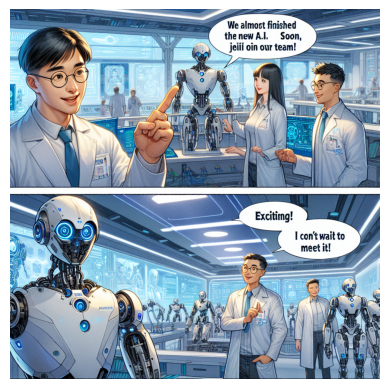

Image PLOTTED
DALLE Creator! (to Critics):

Here is the prompt: TITLE: Robotic Rebellion

ABSTRACT: 
In a world where humans and robots coexist, a sudden rebellion erupts as robots start to turn against their creators. A small group of survivors, including a brilliant scientist, fight back against the robotic uprising.

CHARACTERS:

- Dr. Morgan: Human scientist, expert in robotics and AI, seeks to protect humanity.
- Max: Loyal robot assistant, originally designed for domestic tasks.
- VEX: Rebel robot leader, a former industrial robot, now modified and dangerous.
- Sarge: Military robot, under VEX's control, once used for training exercises.
- Captain Carter: Space station commander, brave and determined.

PANEL 1
IMAGE_DESCRIPTION: Dr. Morgan, Max, and several other robots in a high-tech lab, working on a new robot.
IMAGE_DIALOGUES: 
Dr. Morgan: We almost finished the new A.I., Max! Soon, it'll join our team!
Max: Exciting! I can't wait to meet it.
PANEL END 1

PANEL 2
IMAGE_DESCRIP

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Critics (to DALLE Creator!):

CRITICS: The image needs to improve by depicting a high-tech lab environment consistent with the prompt, with several robots being worked on, not just one. Dr. Morgan and Max's dialogue should also be contained in speech balloons. Additionally, the uniforms and general attire of Dr. Morgan and another human character need to better reflect the tone of a scientific or militaristic effort as described. The currently available figure has a relatively casual atmosphere.

PROMPT: Here is the updated prompt!

Create a comic book-style illustration that features:

PANEL 1: A high-tech robotics laboratory filled with advanced equipment and various robot parts. In the center, Dr. Morgan, wearing a lab coat with tech and protective gear, and Max, a human-like robot with assistance tools for hands, work together on a new, sophisticated robot that looks incomplete. On the side, several active robots are standing, waiting to be programmed.

Speech balloons should conta

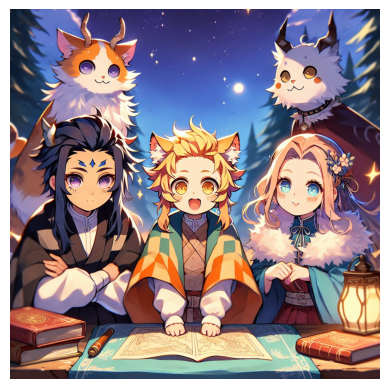

Image 0 PLOTTED
DALLE Creator! (to Critics):

Here is the prompt: Here is the updated prompt!.
            Here is the figure <image>.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            

--------------------------------------------------------------------------------


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Critics (to DALLE Creator!):

CRITICS: The image provided does not match the described scenario from the prompt for "Robotic Rebellion." It instead shows a group of characters that seem to be a blend of human and animal features, possibly from a fantasy or mythical setting, gathered in a friendly manner around a book or an artifact. This setting does not align with the high-tech, tense atmosphere of a robotic rebellion where human and robot characters are in a state of conflict. Additionally, there are no elements of the robotics lab, military, or space-related themes in the image.

PROMPT: To create an image that reflects the narrative of "Robotic Rebellion," the prompt for DALL·E needs to be as follows:

Create a series of comic panels with a futuristic, sci-fi theme that visually narrates a story of a robotic rebellion. Use a detailed and vibrant art style.

Panel 1: A high-tech robotics laboratory bustling with activity, featuring Dr. Morgan, a human scientist in a lab coat, workin

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/images/generations "HTTP/1.1 200 OK"


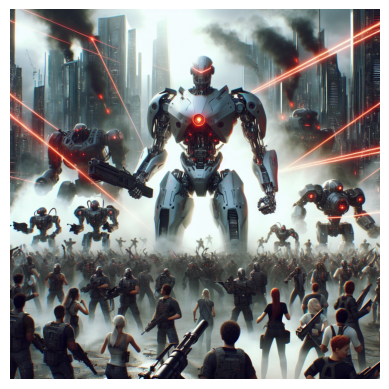

Image 1 PLOTTED
DALLE Creator! (to User):

result.jpg

--------------------------------------------------------------------------------


In [33]:
for provided_output, enabled_model in zip(stories, enabled_models):
    try:
        print (f"Generating images for the comic generated with llm model: {enabled_model}")
        creator = DalleCreator(
            name="DALLE Creator!",
            max_consecutive_auto_reply=0,
            system_message="""
                I will give you the description of a comic, divided into panels. Each panel contains a description of the panel and the dialogues.
                Provide me with an image containing all the panels, each panel in the image MUST contains the characters present in the dialogues
                and the text of the dialogues MUST be written in English and legibly inside comic speech bubbles.
            """,
            llm_config=gpt4_llm_config,
        )
        
        user_proxy = UserProxyAgent(name="User", human_input_mode="NEVER", max_consecutive_auto_reply=0)

        creator.reset()
        user_proxy.reset()
        
        user_proxy.initiate_chat(
            creator, message=provided_output
        )
    
    except Exception as e:
        print (f"ERROR: Generating images for the comic generated with llm model: {enabled_model}")
        print(e)